# Testing hypotheses for increasing revenue in an online store by evaluating the results of an A / B test

**File orders.csv**

transactionId - order identifier;

visitorId - identifier of the user who made the order;

date - the date when the order was made;

revenue - order revenue;

group - the group of the A / B test 

**File visits.csv**

date - date;

group - A / B test group;

visitors - the number of users on the specified date in the specified A / B test group

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats 

In [2]:
orders = pd.read_csv('/Users/yuliyapletneva/orders.csv')
visits = pd.read_csv('/Users/yuliyapletneva/visitors.csv', sep=',')

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
orders.duplicated().sum()

0

In [9]:
#check if there are users who fall into both groups
groupA = orders.query('group == "A"').drop_duplicates().reset_index(drop = False)
groupB = orders.query('group == "B"').drop_duplicates().reset_index(drop = True)
groupAvisitors = groupA['visitorId'].unique()
groupB.query('visitorId in @groupAvisitors')


,transactionId,visitorId,date,revenue,group
12,2904772834,963407295,2019-08-15,300,B
15,4252514150,351125977,2019-08-15,15185,B
16,1162046357,3234906277,2019-08-15,7555,B
17,1630050528,237748145,2019-08-15,7620,B
21,3666913472,2038680547,2019-08-15,1680,B
...,...,...,...,...,...
627,3898641900,3803269165,2019-08-14,790,B
628,1373388206,3717692402,2019-08-14,2400,B
632,2682156369,1668030113,2019-08-14,1290,B
633,1329499668,2949041841,2019-08-14,10380,B


In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [13]:
visits['date'].min()

Timestamp('2019-08-01 00:00:00')

In [14]:
visits['date'].max()

Timestamp('2019-08-31 00:00:00')

In [15]:
visits.duplicated().sum()

0

The orders dataset contains data on 1197 orders on the site, all data correspond to their types, there are no duplicates in the table. 92 people were included in both groups. 

The visits table contains aggregated data for visits by day. The date column needed to be converted to date format.
    
There are no missing values or duplicates.
    
All data for the period from 01/08/2019 to 31/08/2019

### Plotting the cumulative revenue by group

In [16]:
# create an array of unique pairs of date values and test groups
datesGroups = orders[['date','group']].drop_duplicates()


In [17]:
datesGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 1150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ KB


In [18]:
# getting aggregated cumulative daily data on orders
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [19]:
# getting aggregated cumulative daily data about visitors to the online store
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [20]:
# combining cumulative data in one table and assign clear names to its columns
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


In [21]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


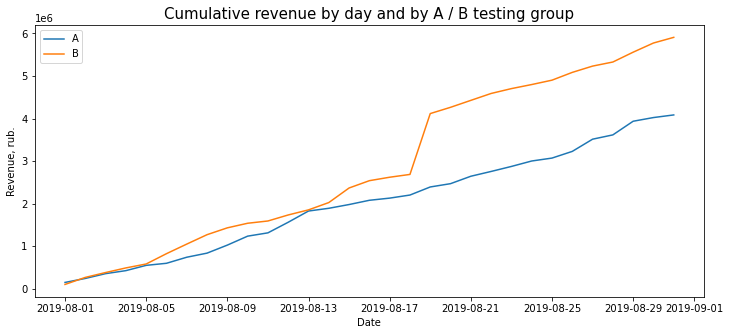

In [22]:
warnings.filterwarnings("ignore")
# dataframe with cumulative number of orders and cumulative revenue by day in group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# dataframe with cumulative number of orders and cumulative revenue by day in group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 5))
# graph of the revenue of group A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# graph of the revenue of group B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('Cumulative revenue by day and by A / B testing group', fontsize=15)
plt.xlabel("Date")
plt.ylabel("Revenue, rub.")
plt.show()

Until about the middle of the test, revenue increases evenly for both groups. But then there is a significant discrepancy, where group B outperforms group A. In group B there is a very sharp jump, which may signal spikes in the number of orders, or the appearance of very expensive orders in group B.

### Plotting the cumulative average check by group.

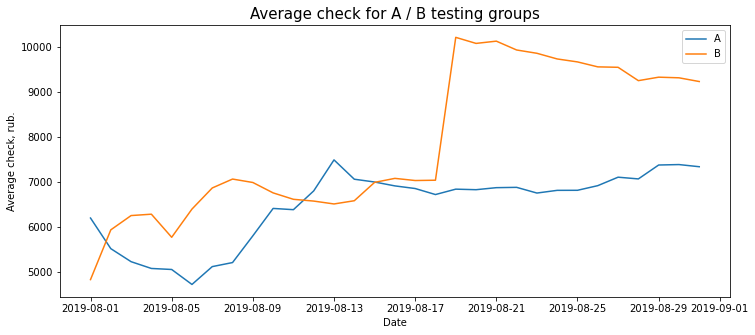

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('Average check for A / B testing groups', fontsize=15)
plt.xlabel("Date")
plt.ylabel("Average check, rub.")
plt.show()

The average check also rises sharply for group B, which confirms that a large order got there. To correctly analyze the graph, it is necessary to get rid of outliers. 

### Plotting the relative change in the cumulative average check of group B to group A.

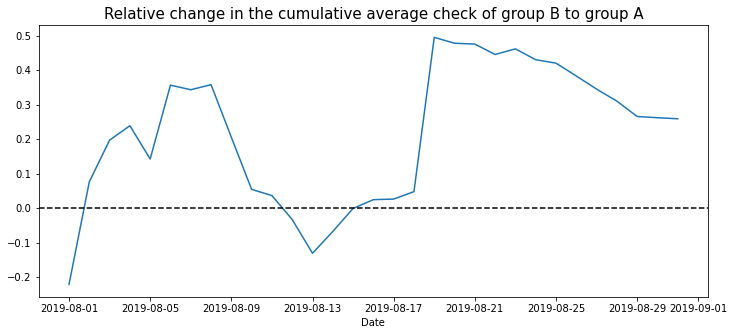

In [24]:
# merging data in one dataframe
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# building the ratio of average checks
plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# add the X axis
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative change in the cumulative average check of group B to group A', fontsize=15)
plt.xlabel("Date")
plt.show()

As shown in the previous graphs, the data contains outliers. At several points, the graph of differences between groups jumps sharply.

### Plotting the cumulative conversion rate by group

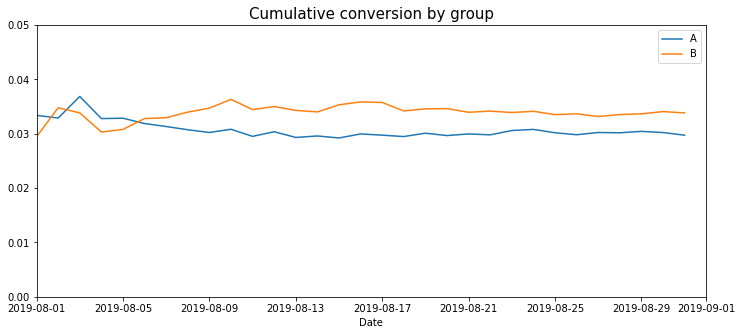

In [25]:
# calculate the cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])
plt.title('Cumulative conversion by group', fontsize=15)
plt.xlabel("Date")
plt.show()

At the beginning of the test, the conversion fluctuated slightly, but then stabilized in both groups, while the conversion in group B consistently exceeded the conversion in group A

### Plotting the relative change in the cumulative conversion of group B to group A.

No handles with labels found to put in legend.


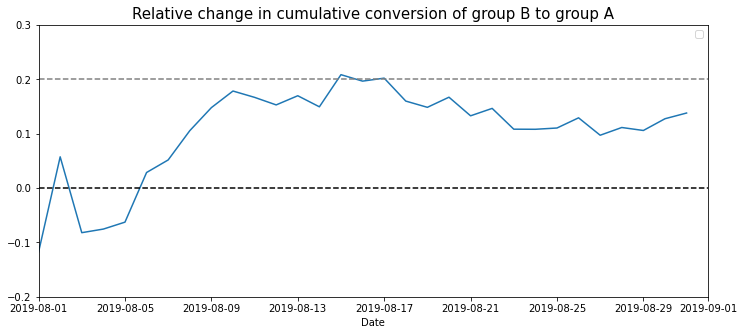

In [26]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                              .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']))

plt.figure(figsize=(12, 5))
(plt.plot(mergedCumulativeConversions['date'], 
          mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
)
 
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.3])
plt.title('Relative change in cumulative conversion of group B to group A', fontsize=15)
plt.xlabel("Date")
plt.show()


After stabilizing conversions, Group B confidently outperformed Group A throughout the test.

### Scatterplot of the number of orders by user

In [27]:
orders_per_user = (orders.drop(['group', 'revenue', 'date'], axis = 1)
                  .groupby('visitorId')
                  .agg({'transactionId' : 'nunique'})
                  .reset_index()
            )

In [28]:
orders_per_user.head()

,visitorId,transactionId
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


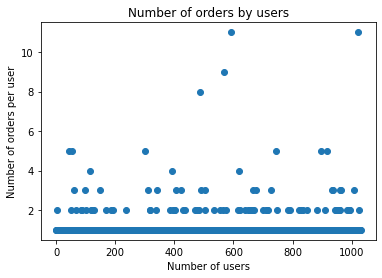

In [29]:
x_values = pd.Series(range(0,len(orders_per_user['transactionId'])))
plt.scatter(x_values, orders_per_user['transactionId']) 
plt.title('Number of orders by users')
plt.xlabel("Number of users")
plt.ylabel("Number of orders per user")
plt.show()

### Calculating the 95th and 99th percentiles of the number of orders per user

In [30]:
print(np.percentile(orders_per_user['transactionId'], [95, 99]))

[2. 4.]


We can exclude those who have ordered more than three times, so we will remove from 1% to 5% of users.

### Scatterplot of order costs

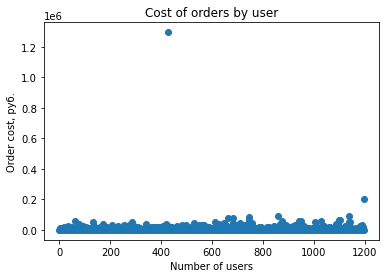

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Cost of orders by user')
plt.xlabel("Number of users")
plt.ylabel("Order cost, руб.")
plt.show()

### Calculating the 95th and 99th percentiles of the order cost

In [32]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


One outlying order is visible here, which most likely distorts all indicators. We can filter out 5% of users with orders over 28,000.

In [33]:
visitorsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [34]:
visitorsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [35]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [36]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [37]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64
(63,)


### Calculate the statistical significance of differences between groups in conversion based on the "cleaned" data

*** null hypothesis H₀: *** conversion rates between groups A and B are equal

*** alternative hypothesis H₁: *** conversion rates between groups A and B are not equal

In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [41]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.018
0.148


There is a statistically significant difference between the conversions of groups A and B (p <0.05).

Group B has a relative gain of 14.8%.

### Calculating the statistical significance of the differences in the average order cost between groups based on "cleaned" data

In [42]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative = 'two-sided'
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.977
-0.017


The non-outlier data showed that the difference between the average checks was only 1.7% in favor of group A.

#### Conclusion
The results of the A / B test showed a confident superiority of group B over group A in terms of conversion rates, although there were no differences in terms of the average check. Thus, the innovation that was tested in group B significantly increases conversion in an internet store.